In [19]:
import json

LOG_DIR = "benchmark_logs"

LOG_PATH = f"{LOG_DIR}/deepseek-r1-14b_20250716-135617.jsonl"
LOG_PATH = f"{LOG_DIR}/phi4-before-system-prompt.jsonl"

def find_llm_true_others_false(log_path):
    with open(log_path, "r") as f:
        lines = f.readlines()

    filtered = []
    for line in lines:
        entry = json.loads(line)
        if (
            entry.get("llm_equivalent") is True and
            entry.get("match_exact") is False and
            entry.get("match_ast") is False
        ):
            filtered.append(entry)

    print(f"Found {len(filtered)} cases where LLM judged True but exact and AST are False.\n")

    for i, entry in enumerate(filtered, 1):
        print(f"--- Case #{i} ---")
        print(f"Example ID: {entry['example_id']}")
        print(f"Prompt:\n{entry['prompt']}\n")
        print(f"Reference SQL:\n{entry['reference_sql']}\n")
        print(f"Generated SQL:\n{entry['generated_sql']}\n")
        print(f"LLM Explanation:\n{entry['llm_explanation']}\n")
        print("="*60)

if __name__ == "__main__":
    find_llm_true_others_false(LOG_PATH)


Found 39 cases where LLM judged True but exact and AST are False.

--- Case #1 ---
Example ID: 3792
Prompt:
What is the maximum distance traveled by an electric vehicle in a single trip, grouped by vehicle model?

Reference SQL:
SELECT evm.vehicle_model, MAX(trips.distance) AS max_distance_traveled FROM Trips trips INNER JOIN ElectricVehicleModels evm ON trips.vehicle_id = evm.vehicle_id GROUP BY 1;

Generated SQL:
SELECT 
    evm.vehicle_model,
    MAX(t.distance) AS max_distance
FROM 
    Trips t
JOIN 
    ElectricVehicleModels evm ON t.vehicle_id = evm.vehicle_id
GROUP BY 
    evm.vehicle_model;

LLM Explanation:
Both queries retrieve the maximum distance traveled per vehicle model by joining the Trips and ElectricVehicleModels tables. The reference query uses GROUP BY 1 (first column) while the generated query explicitly groups by evm.vehicle_model. Since the first column in the SELECT list is vehicle_model, both grouping strategies are equivalent. The table aliases (trips vs t) an

In [ ]:
from __future__ import annotations
import argparse, json, pathlib, sys
import pandas as pd


def load_jsonl(path: pathlib.Path) -> pd.DataFrame:
    """Read a JSONL benchmark log into a DataFrame."""
    with path.open() as fp:
        rows = [json.loads(ln) for ln in fp if ln.strip()]
    df = pd.DataFrame(rows)
    df["source_log"] = path.name          # keep origin for later
    return df


def summarise(df: pd.DataFrame) -> None:
    """Print an aggregated overview."""
    n = len(df)
    if n == 0:
        print("No rows ⇒ nothing to summarise.\n")
        return

    tot_lat   = df["latency_sec"].sum()
    tot_tok   = df["tokens_total"].fillna(0).sum()
    tot_prm   = df["tokens_prompt"].fillna(0).sum()
    tot_cmp   = df["tokens_completion"].fillna(0).sum()
    avg_lat   = tot_lat / n
    avg_tok   = tot_tok / n
    tps       = tot_tok / tot_lat if tot_lat else None

    exact_ok  = df["match_exact"].mean() * 100
    ast_ok    = df["match_ast"].mean()   * 100
    llm_ok    = df["llm_equivalent"].mean() * 100 if "llm_equivalent" in df else None

    print(f"Rows analysed          : {n:,}")
    print(f"Σ latency              : {tot_lat:,.2f}  s")
    print(f"Σ tokens (prompt+comp) : {tot_tok:,.0f}")
    print(f"  – prompt             : {tot_prm:,.0f}")
    print(f"  – completion         : {tot_cmp:,.0f}")
    print(f"Avg latency / query    : {avg_lat:,.2f}  s")
    print(f"Avg tokens / query     : {avg_tok:,.1f}")
    if tps:
        print(f"Overall throughput     : {tps:,.1f} tokens/sec")
    print()
    print(f"Exact-match accuracy   : {exact_ok:5.1f} %")
    print(f"AST-match accuracy     : {ast_ok:5.1f} %")
    if llm_ok is not None:
        print(f"LLM-judge equivalence  : {llm_ok:5.1f} %")
    print("-" * 40, "\n")




df = load_jsonl(pathlib.Path(LOG_PATH))
summarise(df)

TypeError: unsupported operand type(s) for /: 'str' and 'int'

In [11]:
from text2sql_lib.visualize import visualize_benchmark_results, visualize_benchmark_results2

# visualize_benchmark_results("benchmark_results.jsonl")

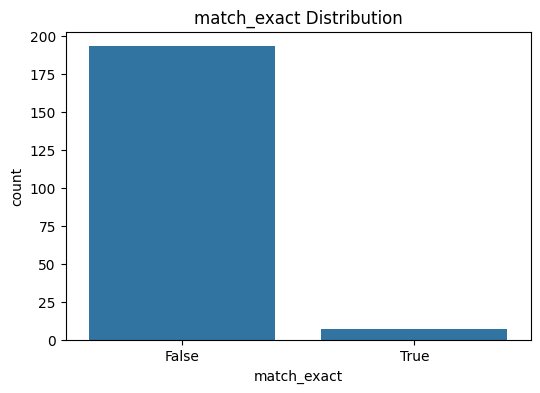

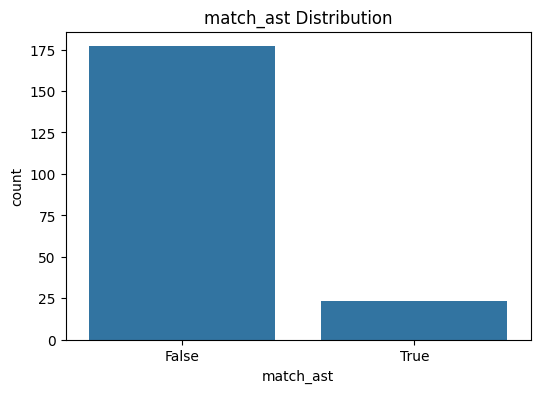

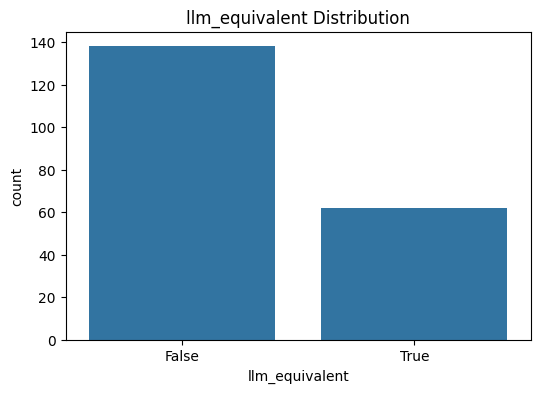

match_exact       0.035
match_ast         0.115
llm_equivalent    0.310
dtype: float64


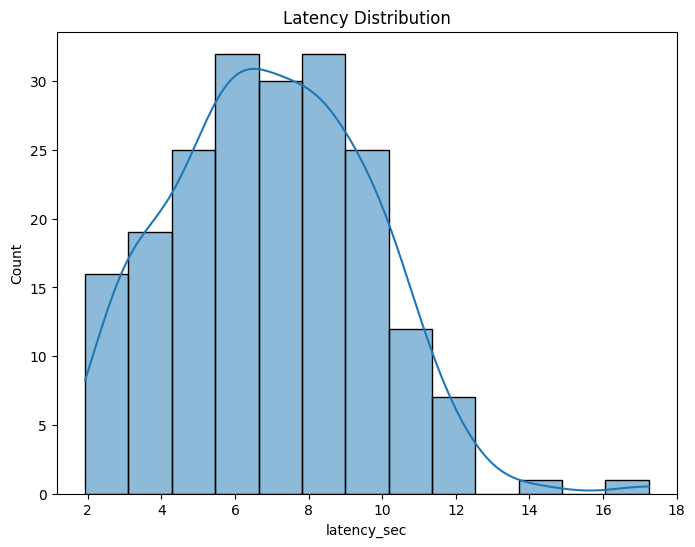

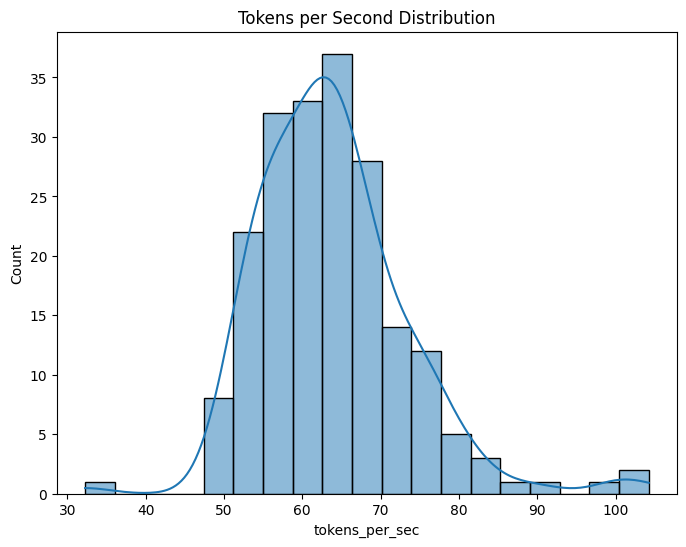

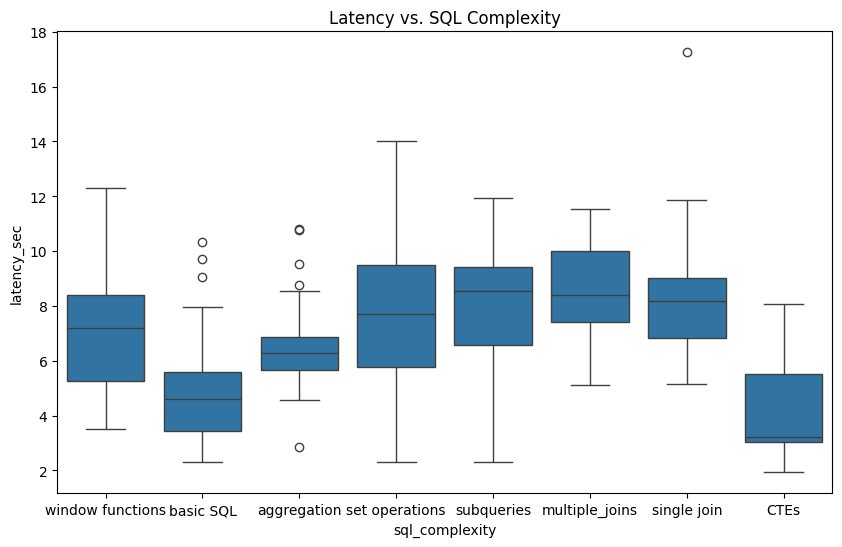

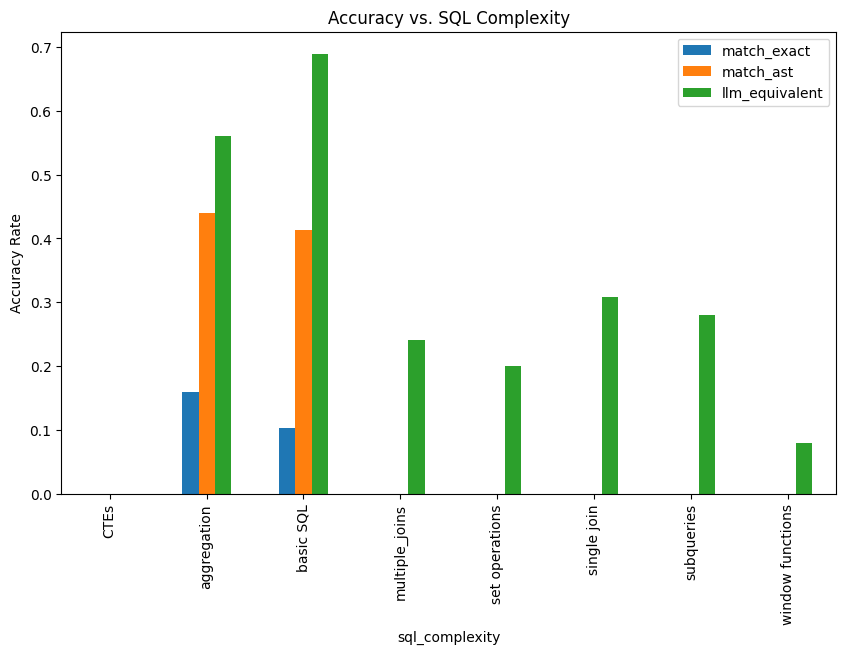

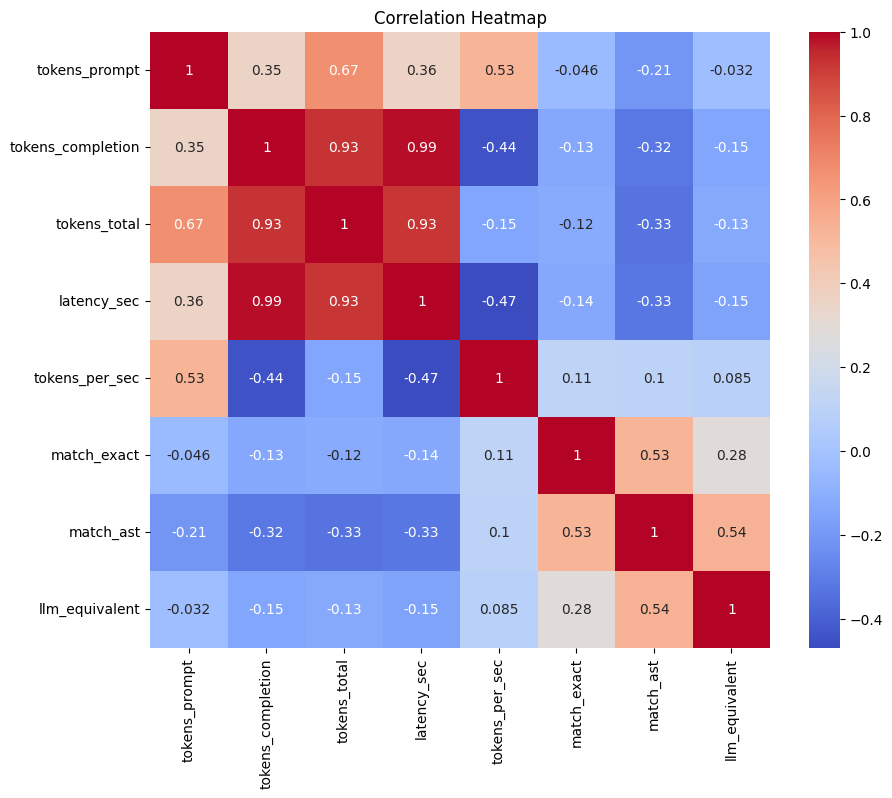

In [12]:
visualize_benchmark_results2(LOG_PATH)

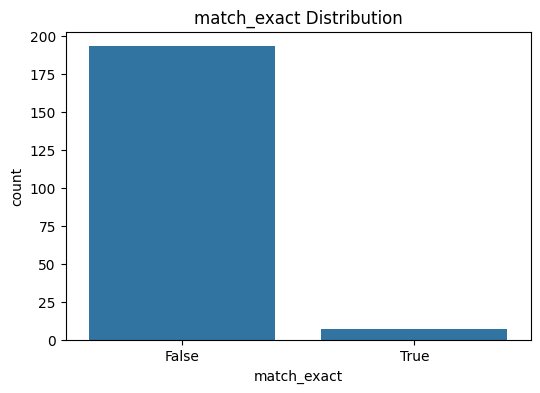

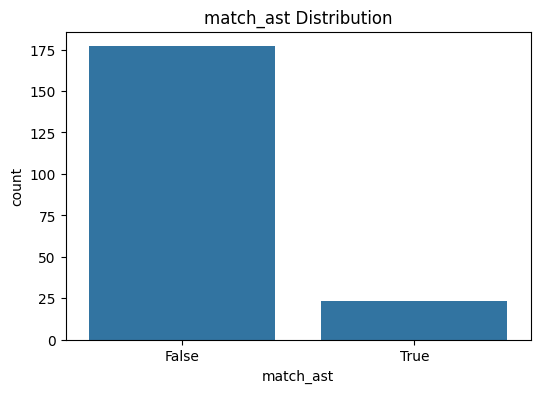

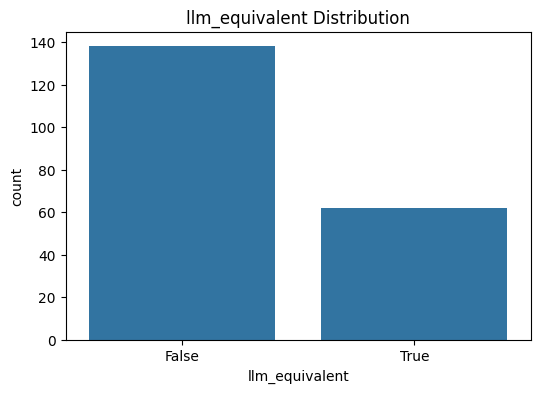

match_exact       0.035
match_ast         0.115
llm_equivalent    0.310
dtype: float64


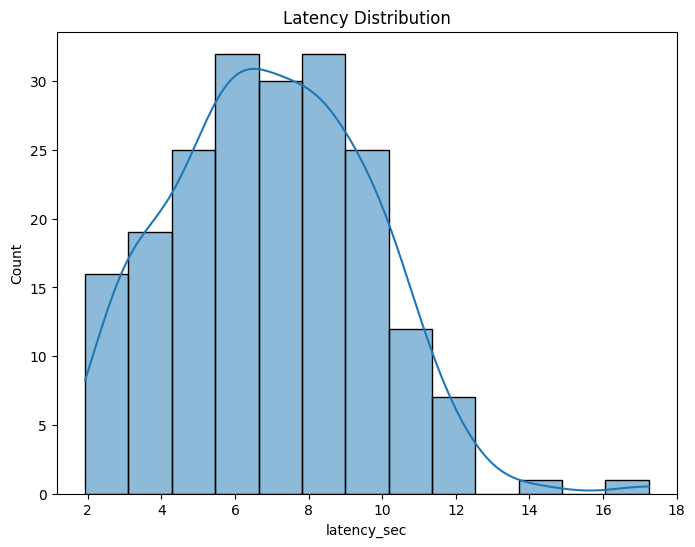

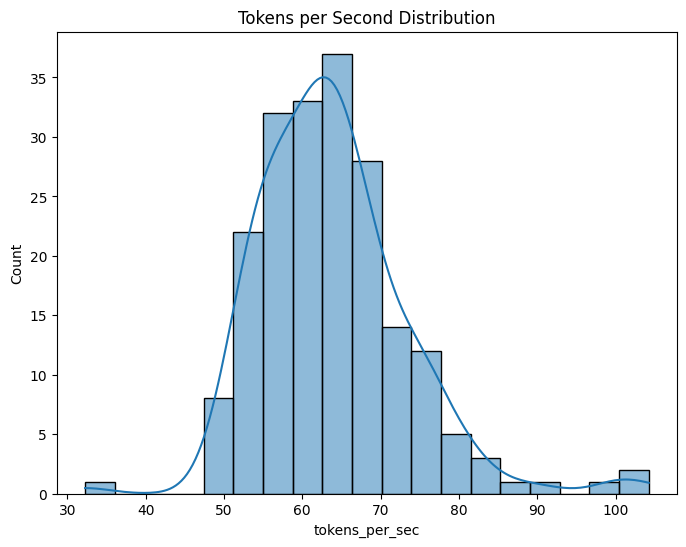

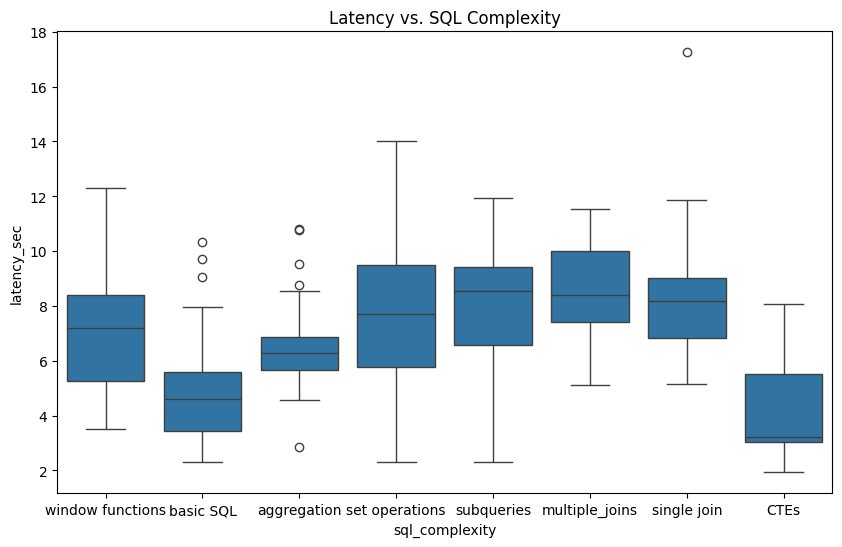

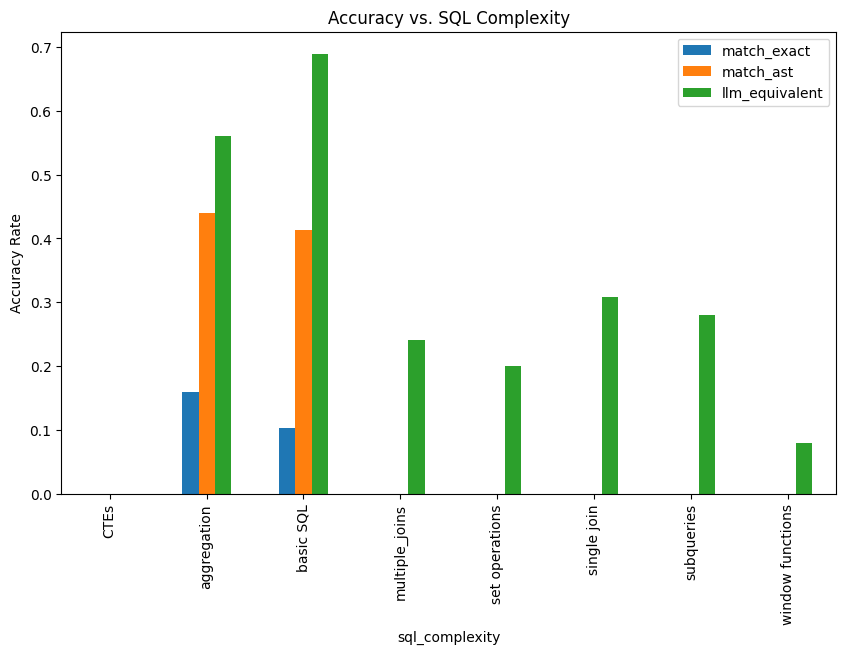

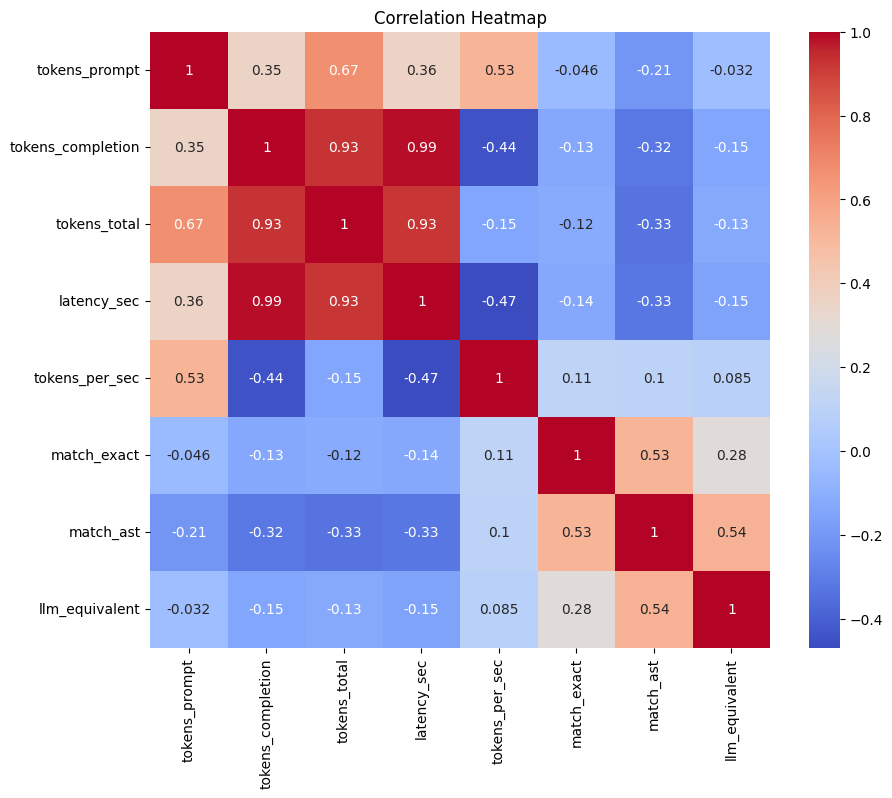

In [13]:
visualize_benchmark_results2(LOG_PATH)